In [1]:
import os
import sys 

current_directory = os.getcwd()
models_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(models_directory)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import seaborn as sns
import itertools

import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.lines import Line2D

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results

from vecopsciml.operators.zero_order import Mx, My

In [3]:
from models.baseline.model import BaselineNonlinearModel
from models.autoencoder.model import Autoencoder, AutoencoderNonlinearModel
from models.fourier.model import FFTNonlinearModel
from models.POD.model import PODNonlinearModel

In [4]:
def smooth_curve(data, window_size=1000):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [5]:
data_name = 'non_linear_5000_1'
n_modes = 50

# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'baseline_model_') + str(n_modes)

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear_5000_1
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear_5000_1/baseline_model_50


In [6]:
dataset = load_data(DATA_PATH)

# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_5000_1/non_linear_5000_1.pkl


In [7]:
def relative_error(validation, prediction, dx=dx, dy=dy):

    # validation = validation.numpy()
    # prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    return prediction_error

In [8]:
DEVICE = torch.device("cpu")

In [9]:
def er_sum(reshaped_predicted_K, reshaped_validation_K, dx=dx, dy=dy):

    numerador = np.sum((np.trapz(np.trapz(reshaped_predicted_K - reshaped_validation_K, dx=dx), dx=dx))**2)
    denominador = np.sum((np.trapz(np.trapz(reshaped_validation_K, dx=dx), dx=dx))**2)
    
    er = numerador  / denominador

    return er
    
    print(f"er(K): {er:.2e}")

In [10]:
def dataframe_a_latex(df, nombre_archivo=None, index=False, caption=None, label=None):
    """
    Convierte un DataFrame en una tabla LaTeX.
    
    Args:
        df (pd.DataFrame): DataFrame a convertir.
        nombre_archivo (str): Ruta para guardar el archivo .tex (opcional).
        index (bool): Si se incluye o no el índice.
        caption (str): Título de la tabla (opcional).
        label (str): Etiqueta de la tabla para referencia cruzada (opcional).
    
    Returns:
        str: La cadena en formato LaTeX.
    """
    latex_str = df.to_latex(index=index, caption=caption, label=label, escape=False)

    if nombre_archivo:
        with open(nombre_archivo, 'w', encoding='utf-8') as f:
            f.write(latex_str)
    
    return latex_str

In [18]:
# N = [10, 100, 1000] 
# R = [0, 1, 5]
# n_modes = [5, 10, 50]

N = [1000] 
R = [0]
n_modes = [20]
models = ['baseline_model_', 'POD_model_', 'model_autoencoder_NN_', 'FFT_model_']

for model_i in models:
    print(model_i)
    combinations = list(itertools.product(N, R, n_modes))
    n_data_vals, ruido_vals, modos_vals = zip(*combinations)
    multi_index = pd.MultiIndex.from_arrays([n_data_vals, ruido_vals, modos_vals], names=["N_data", "Sigma", "Mode"])

    error_table = pd.DataFrame(index=multi_index, columns=["Hyperparameters", "time", "eQ1", "eQ2", "eQ3", "eK"])

    for n_i in N:
        for r_i in R:
            for mode_i in n_modes:
                
                data_name = f'non_linear_{n_i}_{r_i}'

                # Creamos los paths para las distintas carpetas
                ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
                DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
                RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)
                MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_i) + str(mode_i)

                dataset = load_data(DATA_PATH)

                # Train data splitting in train/test
                X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
                y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
                K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
                f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

                X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

                # Data processing and adequacy with our TensOps library
                X_train = X_train.to(DEVICE)
                X_test = X_test.to(DEVICE)

                y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                # Loading and processing validation data
                X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
                y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
                K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
                f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

                # Predictive network architecture
                input_shape = X_train[0].shape
                predictive_layers = [20, 10, mode_i, 10, 20]
                predictive_output = y_train.values[0].shape

                # Explanatory network architecture
                explanatory_input = Mx(My(y_train)).values[0].shape
                explanatory_layers = [10]
                explanatory_output = Mx(My(f_train)).values[0].shape

                # Other parameters
                n_filters_explanatory = 5

                
                if model_i == 'baseline_model_':
                    try:
                        model = BaselineNonlinearModel(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                elif model_i == 'POD_model_':
                    try:
                        if X_train.shape[0] < mode_i:
                            continue

                        U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1), full_matrices=False)
                        U_reduced_train = U_train[:, :mode_i]
                        S_reduced_train = S_train[:mode_i]
                        Vt_reduced_train = Vt_train[:mode_i, :]
                        POD_base = Vt_reduced_train.to(DEVICE)

                        model = PODNonlinearModel(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
                            time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

                        time = np.cumsum(lists['time_list'])[-1] + time_pod

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                elif model_i == 'FFT_model_':
                    try:
                        model = FFTNonlinearModel(input_shape, predictive_layers, mode_i, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
                    
                    except:
                        pass

                elif model_i == 'model_autoencoder_NN_':
                    try:
                        MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_AE_') + str(mode_i)
                        MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_NN_') + str(mode_i)

                        autoencoder_input_shape = y_train.values[0].shape
                        latent_space_dim = [20, 10, mode_i, 10, 20]
                        autoencoder_output_shape = y_train.values[0].shape

                        autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
                        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

                        autoencoder, optimizer, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

                        hyperparameters_ae = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

                        time_ae = np.cumsum(lists['time_list'])[-1]

                        pretrained_encoder = autoencoder.encoder
                        pretrained_decoder = autoencoder.decoder

                        for param in pretrained_decoder.parameters():
                            param.requires_grad = False

                        pgnniv_model = AutoencoderNonlinearModel(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                                        explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

                        model, optimizer, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = time_ae + np.cumsum(lists['time_list'])[-1]

                        hyperparameters = hyperparameters_ae + sum(p.numel() for p in model.parameters() if p.requires_grad)

                        
                    except:
                        pass
                
                u_train = y_train.values.detach().numpy() 
            
                u_train = y_train.values.detach().numpy() 
                u_predicted_train = model(X_train)[0].detach().numpy() 
                er_u_train = relative_error(u_train, u_predicted_train).flatten()

                erQ1_u = np.percentile(er_u_train, 25)
                erQ2_u = np.percentile(er_u_train, 50)
                erQ3_u = np.percentile(er_u_train, 75)



                u_min = u_train.flatten().min()
                u_max = u_train.flatten().max()
                steps = 1000
                u_for_validating = torch.linspace(u_min, u_max, steps=steps).view(steps, 1, 1, 1)
                K_for_validating = (u_for_validating*(1-u_for_validating)).detach().cpu().numpy()
                K_predicted_for_validating = model.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
                diff_squared = (K_predicted_for_validating - K_for_validating) ** 2
                true_squared = K_for_validating ** 2
                u_vals = u_for_validating.numpy().flatten()
                numerator = np.sqrt(np.trapz(diff_squared.flatten(), u_vals))
                denominator = np.sqrt(np.trapz(true_squared.flatten(), u_vals))

                er_K_train = numerator / denominator


                # K_train_ = Mx(My(K_train)).values.detach().numpy() 
                # K_predicted_train = model(X_train)[1].detach().numpy()
                # er_K_train = er_sum(K_train_, K_predicted_train)

                tiempo_minutos = time / 60

                idx = (n_i, r_i, mode_i)
                error_table.loc[idx, "Hyperparameters"] = hyperparameters
                error_table.loc[idx, "time"] = f"{tiempo_minutos:.2f}"
                error_table.loc[idx, "eQ1"] = f"{erQ1_u:.2e}"
                error_table.loc[idx, "eQ2"] = f"{erQ2_u:.2e}"
                error_table.loc[idx, "eQ3"] = f"{erQ3_u:.2e}"
                error_table.loc[idx, "eK"] = f"{er_K_train:.2e}"
                

    print(model_i)
    print(error_table)
    tiempo_segundos = time
    tiempo_minutos = tiempo_segundos / 60
    print(f"Tiempo actual en segundos: {tiempo_segundos}")
    print(f"Tiempo actual en minutos: {tiempo_minutos}")
    print("\n")
                

    tabla_latex = dataframe_a_latex(error_table, 
                                    nombre_archivo=os.path.join(os.getcwd(), "error_tables", f"error_{model_i}"), 
                                    index=multi_index,
                                    caption="Tabla con formato LaTeX",
                                    label="tab:formateada")

baseline_model_
Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_1000_0/non_linear_1000_0.pkl
baseline_model_
                  Hyperparameters    time       eQ1       eQ2       eQ3  \
N_data Sigma Mode                                                         
1000   0     20              4711  264.38  9.83e-05  1.31e-04  2.01e-04   

                         eK  
N_data Sigma Mode            
1000   0     20    1.19e-01  
Tiempo actual en segundos: 15862.957343816757
Tiempo actual en minutos: 264.382622396946


POD_model_
Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_1000_0/non_linear_1000_0.pkl
POD_model_
                  Hyperparameters    time       eQ1       eQ2       eQ3  \
N_data Sigma Mode                                                         
1000   0     20              2181  254.07  2.21e-04  3.03e-04  4.11e-04   

                 

In [17]:
fgasdfasd

NameError: name 'fgasdfasd' is not defined

In [ ]:
dsdfsadf

In [ ]:
N = [10, 20, 50, 100, 1000, 5000, 10000] 
R = [0, 1, 5, 10]
n_modes = [0, 1, 2, 5, 10, 20, 50, 100]


model_i = 'model_autoencoder_NN_'
data_name = f'non_linear_{N}_{R}'


mode_i = n_modes

# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_i) + str(n_modes)

dataset = load_data(DATA_PATH)

# Train data splitting in train/test
X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

# Data processing and adequacy with our TensOps library
X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)

y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

# Loading and processing validation data
X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

# Predictive network architecture
input_shape = X_train[0].shape
predictive_layers = [20, 10, n_modes, 10, 20]
predictive_output = y_train.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train)).values[0].shape
explanatory_layers = [10]
explanatory_output = Mx(My(f_train)).values[0].shape

# Other parameters
n_filters_explanatory = 5


if model_i == 'baseline_model_':
    
    color = 'black'

    model = BaselineNonlinearModel(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

    save_dir = f'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/paper/Baseline_model/K_u_BL_N{N}S{R}M{mode_i}'    

elif model_i == 'POD_model_':
    try:
        color = 'green'

        U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1), full_matrices=False)
        U_reduced_train = U_train[:, :mode_i]
        S_reduced_train = S_train[:mode_i]
        Vt_reduced_train = Vt_train[:mode_i, :]
        POD_base = Vt_reduced_train.to(DEVICE)
        model = PODNonlinearModel(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

        with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
            time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

        save_dir = f'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/paper/POD_model/K_u_POD_N{N}S{R}M{mode_i}'


    except:
        pass
elif model_i == 'FFT_model_':
 
    color = 'blue'

    model = FFTNonlinearModel(input_shape, predictive_layers, mode_i, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

    save_dir = f'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/paper/FFT_model/K_u_FFT_N{N}S{R}M{mode_i}'


elif model_i == 'model_autoencoder_NN_':

    color = 'red'

    MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_AE_') + str(n_modes)
    MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, 'model_autoencoder_NN_') + str(n_modes)

    autoencoder_input_shape = y_train.values[0].shape
    latent_space_dim = [20, 10, n_modes, 10, 20]
    autoencoder_output_shape = y_train.values[0].shape

    autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

    autoencoder, optimizer, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

    time_ae = np.cumsum(lists['time_list'])[-1]

    pretrained_encoder = autoencoder.encoder
    pretrained_decoder = autoencoder.decoder

    pgnniv_model = AutoencoderNonlinearModel(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                    explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
    optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

    model, optimizer, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

    save_dir = f'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/paper/Autoencoder_model/K_u_AE_N{N}S{R}M{mode_i}'



else:
    raise ValueError("Not available.")   


u_train = y_train.values.detach().numpy() 
u_predicted_train = model(X_train)[0].detach().numpy() 
er_u_train = relative_error(u_train, u_predicted_train).flatten()

K_train_ = Mx(My(K_train)).values.detach().numpy() 
K_predicted_train = model(X_train)[1].detach().numpy() 
er_K_train = relative_error(K_train_, K_predicted_train).flatten()

er_K_train = er_sum(K_train_, K_predicted_train)

width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

plt.figure(figsize=(height, height))
plt.scatter(u_train.flatten(), ((K_train)).values.detach().numpy().flatten(), label='Prediction', color='red', s=5, alpha=0.3)
plt.scatter(Mx(My(y_train)).values.detach().numpy() , K_predicted_train.flatten(), label='Validation', color='black', s=3, alpha=0.5)

plt.xlabel('$u(x, y)$', fontsize=label_fontsize)
plt.ylabel('$k(u)$', fontsize=label_fontsize)
# plt.title('Lineal homogeneous normalized learning curves', fontsize=s)

mantissa, exponent = f"{er_K_train:.2e}".split("e")
exponent = int(exponent)  # Elimina ceros a la izquierda
plt.title(rf"$\varepsilon_r (K)$ = {mantissa} $\times$ 10$^{{{exponent}}}$", fontsize=label_fontsize-1)


plt.grid(True)
# Obtener la leyenda actual y cambiar el orden
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  # Cambiar el orden de las etiquetas aquí (Validation primero, Prediction segundo)
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

min = torch.min(y_train.values.flatten()) - 0.1*(torch.max(y_train.values.flatten() - torch.min(y_train.values.flatten())))
max = torch.max(y_train.values.flatten()) + 0.1*(torch.max(y_train.values.flatten() - torch.min(y_train.values.flatten())))

xlim = plt.xlim()
ylim = plt.ylim()

# plt.xlim(min, max)
# plt.ylim(0.7, 1.1)

plt.savefig(save_dir+'.png', bbox_inches='tight', dpi=600)
plt.show()

File not found: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_[10, 20, 50, 100, 1000, 5000, 10000]_[0, 1, 5, 10]/non_linear_[10, 20, 50, 100, 1000, 5000, 10000]_[0, 1, 5, 10].pkl



KeyboardInterrupt



In [ ]:
u_train = y_train.values.detach().numpy() 
u_predicted_train = model(X_train)[0].detach().numpy() 
er_u_train = relative_error(u_train, u_predicted_train).flatten()

u_val = y_val.values.detach().numpy() 
u_predicted_val = model(X_val)[0].detach().numpy() 
er_u_val = relative_error(u_val, u_predicted_val).flatten()

K_train_ = Mx(My(K_train)).values.detach().numpy() 
K_predicted_train = model(X_train)[1].detach().numpy() 
er_K_train = relative_error(K_train_, K_predicted_train).flatten()

K_val_ = Mx(My(K_val)).values.detach().numpy() 
K_predicted_val = model(X_val)[1].detach().numpy() 
er_K_val = relative_error(K_val_, K_predicted_val).flatten()

In [ ]:
def er_sum(reshaped_predicted_K, reshaped_validation_K, dx=dx, dy=dy):

    numerador = np.sum((np.trapz(np.trapz(reshaped_predicted_K - reshaped_validation_K, dx=dx), dx=dx))**2)
    denominador = np.sum((np.trapz(np.trapz(reshaped_validation_K, dx=dx), dx=dx))**2)
    
    er = numerador  / denominador
    
    print(f"er(K): {er:.2e}")

POD_model_


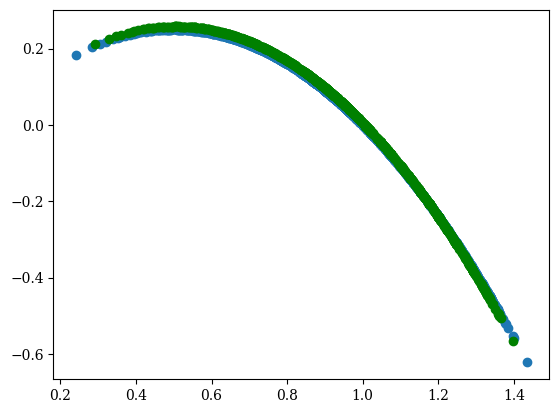

er(K): 1.30e-03
POD_model_


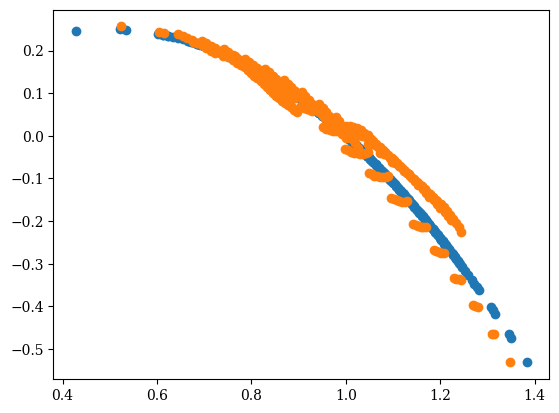

er(K): 9.58e-02


In [ ]:
print(model_i)

plt.scatter(u_train.flatten(), ((K_train)).values.detach().numpy().flatten())
plt.scatter(Mx(My(y_train)).values.detach().numpy() , K_predicted_train.flatten(), color=color)
plt.show()

er_sum(Mx(My(K_train)).values.detach().numpy(), K_predicted_train)


print(model_i)

plt.scatter(u_val.flatten(), ((K_val)).values.detach().numpy().flatten())
plt.scatter(Mx(My(y_val)).values.detach().numpy() , K_predicted_val.flatten())
plt.show()

er_sum(Mx(My(K_val)).values.detach().numpy(), K_predicted_val)

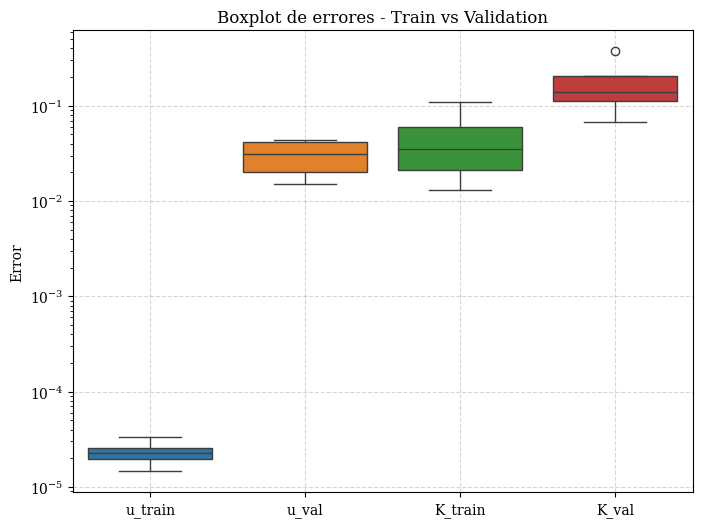

In [ ]:
# Crea una figura
plt.figure(figsize=(8, 6))

# Prepara los datos
data = [er_u_train, er_u_val, er_K_train, er_K_val]
labels = ['u_train', 'u_val', 'K_train', 'K_val']

# Dibuja el boxplot
sns.boxplot(data=data)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.ylabel('Error')
plt.title('Boxplot de errores - Train vs Validation')
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')

# Muestra el gráfico
plt.show()


# K_predicted_train = model(X_train)[1].detach().numpy() 

# u_predicted_val = model(X_val)[0].detach().numpy() 
# K_predicted_val = model(X_val)[1].detach().numpy() 

# er_u_train = relative_error(u_predicted_train, y_train.values)
# er_K_train = relative_error(K_predicted_train, K_train.values)